# GSEA with gseapy

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils
from scripts.analysis import build_loci

In [2]:
BASE = '../data'

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci_adj.pkl.gz"))
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt1_adj.pkl.gz"))
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci_filt1.pkl.gz"))

In [3]:
pd.set_option('precision', 3)

In [4]:
import gseapy as gp
import goatools

obodag = goatools.obo_parser.GODag('go-basic.obo')

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-07-16) 46,953 GO Terms


In [5]:
def make_ranked_df(grouped_loci):
    df = build_loci.get_sig_df(grouped_loci, fc_cutoff=0, p_val_cutoff=.2).query('passes')
    
    # Right now FC ratios are light/heavy
    # light == Tcell and heavy == RAG
    # GSEA goes from low to High, so negative logFC values will come first
    # This will give genes high in RAG highest priority
    # Switching the sign with put the genes highest in Tcell mice up first
    df['logfc'] = -1 * df['logfc']
           
    # filter out the mouse and human genes as well as any Spirulina proteins
    bad_loci = build_loci.get_annotation_df(grouped_loci).query('mouse_human or spir').index.tolist()
    df = df.query('~(id in {})'.format(bad_loci))

    df['id'] = df['id'].astype(str)
    
    # prep the ranking dataframe to gesapy specs.
    rank_df = df[['id', 'logfc']].rename(columns={'id': 'gene_name', 'logfc': 'rank'})
    
    return rank_df.sort_values('rank').reset_index(drop=True)


In [6]:
def make_go2Gene_map(grouped_loci, ontology='MF'):    

    ontology_map = {'MF': 'molecular_function', 'BP': 'biological_process', 'CC': 'cellular_component'}
    
    out = defaultdict(set)    
    for l in grouped_loci:
        if 'go' in l.annotations and l.avg_ratio != 0:
            for go in l.annotations['go']:
                if obodag[go].namespace == ontology_map[ontology]:
                    out[go].add(l.cluster_id)
                    for parent in obodag[go].get_all_parents():
                        if obodag[parent].namespace == ontology_map[ontology]:
                            out[parent].add(l.cluster_id)
                
    return out

In [7]:
def filter_go2gene_map(go_locus):
    
    # Remove "very broad" gene sets. Arbitrary definition: gene sets that emcompass >50% of all IDs
    all_ids = set(chain(*go_locus.values()))
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) / len(all_ids) <= 0.5}

    # Remove terms with less than 5 members: changed from 10 to 5 becasue small #s of proteins compared
    # to what you would find wiht genes
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) >= 5}

    # Remove child terms with identical gene sets as their parents
    to_remove = set()
    for parent in go_locus.keys():
        # If child term has exact same members as parent, remove
        child_ids = [x.id for x in obodag[parent].children if x.id in go_locus.keys()]
        for child in child_ids:
            if go_locus[child] == go_locus[parent]:
                to_remove.add(child)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    # Remove sibling terms with identical gene sets
    to_remove = set()
    to_keep = set()
    for brother in go_locus.keys():
        to_keep.add(brother) # make sure filtered out siblings don't filter out ones we want to keep
        for parent in obodag[brother].parents:
            siblings = set([y.id for y in parent.children])
            siblings.remove(brother)
            for sibling in siblings:
                if sibling in go_locus.keys() and go_locus[brother] == go_locus[sibling] and not sibling in to_keep:
                    to_remove.add(sibling)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    return go_locus

In [8]:
def gomap_to_csv(go2gene, out_file = 'test.tsv'):

    out = ""
    for term, loci in go2gene.items():
        out += "{}\t".format(term)
        out += "{}\t".format(obodag[term].name)
        out += '\t'.join(list(map(str,loci)))
        out += '\n'
        
    with open(out_file, 'w') as fout:
        fout.write(out)

In [9]:
def run_go_gsea(rank_df, g2g_map, seed):
    """
    A ranked df and go2gene mapping returns the result dataframe for GSEA against all go-Terms
    
    loci must be grouped such that avg_ratio and p-values are correct for 1 phenotype
    see rt_unenr_grouped_loci above for example
    """
    import gseapy as gp
        
    # save the go 2 gene map, since gseapy doesn't seem to be able to use one already in memory
    gomap_to_csv(g2g_map, 'temp.gmt')
    
    res = gp.prerank(rnk=rank_df, gene_sets='temp.gmt', outdir='tmp', min_size = 5, max_size=500, 
                     permutation_n = 10000, graph_num = len(g2g_map), savefigs=False, seed=seed)
      
    def get_go_name(term):
        return obodag[term].name
    
    res['name'] = res.index.map(get_go_name)
    
    return res.sort_values('nes', ascending=False)

In [10]:
def plot_gsea_result(row, rank):
    return gp.gsea_plot(rank, row['name'], row.hit_index, row.nes, row.pval, row.fdr, row.rank_ES, phenoPos='Tcell', phenoNeg='RAG')

In [11]:
mf_map = make_go2Gene_map(unenr_grouped_loci)
mf_map_f = filter_go2gene_map(mf_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(mf_map), len(mf_map_f)))

Unfiltered: 516	Filtered: 198


In [12]:
bp_map = make_go2Gene_map(unenr_grouped_loci, 'BP')
bp_map_f = filter_go2gene_map(bp_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(bp_map), len(bp_map_f)))

Unfiltered: 612	Filtered: 208


In [13]:
cc_map = make_go2Gene_map(unenr_grouped_loci, 'CC')
cc_map_f = filter_go2gene_map(cc_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(cc_map), len(cc_map_f)))

Unfiltered: 102	Filtered: 48


In [14]:
unen_rank =  make_ranked_df(unenr_grouped_loci)

../scripts/analysis/build_loci/common.py:153: RuntimeWarning: divide by zero encountered in log10
  df['-logp'] = -1*np.log10(df['p_value'])
../scripts/analysis/build_loci/common.py:161: RuntimeWarning: divide by zero encountered in log2
  cutoff = lambda r: abs(r['logfc'])>np.log2(fc_cutoff) and r['-logp'] > -1*np.log10(p_val_cutoff)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
import warnings
warnings.filterwarnings('ignore')

mf_un_res = run_go_gsea(unen_rank, mf_map_f, seed=1111)
bp_un_res = run_go_gsea(unen_rank, bp_map_f, seed=2222)
cc_un_res = run_go_gsea(unen_rank, cc_map_f, seed=3333)

127 gene_sets have been filtered out when max_size=500 and min_size=5
71 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Oct 26 15:45:48 2016
Start to compute esnulls................................ Wed Oct 26 15:45:48 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Wed Oct 26 15:46:49 2016
start to compute fdrs................................... Wed Oct 26 15:46:49 2016
Statistial testing finished............................. Wed Oct 26 15:46:50 2016
Start to generate gseapy reports, and produce figures... Wed Oct 26 15:46:50 2016
Start to generate gseapy reports, and produce figures... Wed Oct 26 15:46:50 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Wed Oct 26 15:46:50 2016
118 gene_sets have been filtered out when max_size=500 and min_size=5
90 gene_sets used for further calculating
Start 

In [16]:
mf_un_res.to_csv(os.path.join(BASE, 'silam_mf_u.csv'))
bp_un_res.to_csv(os.path.join(BASE, 'silam_bp_u.csv'))
cc_un_res.to_csv(os.path.join(BASE, 'silam_cc_u.csv'))

In [17]:
mf_un_TC = mf_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_un_RAG = mf_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_un_TC = bp_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_un_RAG = bp_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

cc_un_TC = cc_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
cc_un_RAG = cc_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Molecular Function - Up in Tcell

In [18]:
res_cols = ['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']

In [19]:
mf_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0004619,phosphoglycerate mutase activity,0.887,3.838,0.000,0.000,42,31
GO:0016866,intramolecular transferase activity,0.812,3.634,0.000,0.000,66,35
GO:0016868,"intramolecular transferase activity, phosphotr...",0.812,3.620,0.000,0.000,54,35
GO:0016853,isomerase activity,0.736,3.496,0.000,0.000,142,44
GO:0000287,magnesium ion binding,0.577,2.059,0.002,0.007,73,17
GO:0005506,iron ion binding,0.499,1.982,0.003,0.012,125,23
GO:0050661,NADP binding,0.657,1.924,0.004,0.017,29,9
GO:0051287,NAD binding,0.631,1.905,0.006,0.017,40,10
GO:0003677,DNA binding,0.397,1.873,0.003,0.020,135,43


In [20]:
mf_un_TC[res_cols].to_csv(os.path.join(BASE,'mf_un_IBD.csv'))

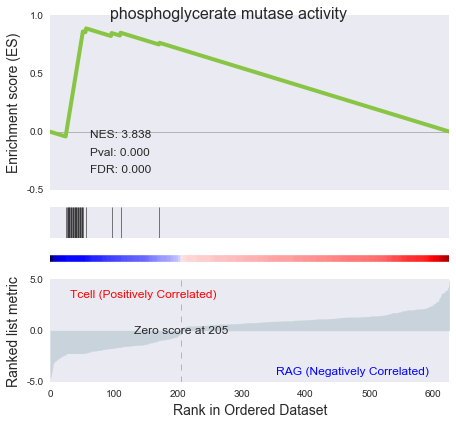

In [21]:
sns.set_style('dark')
plot_gsea_result(mf_un_res.iloc[0], unen_rank)

### Biological Process - Up in Tcell

In [22]:
bp_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0009056,catabolic process,0.610,3.273,0.000,0.000e+00,256,73
GO:0044712,single-organism catabolic process,0.610,3.269,0.000,0.000e+00,228,73
GO:0009135,purine nucleoside diphosphate metabolic process,0.617,3.268,0.000,0.000e+00,202,68
GO:0006733,oxidoreduction coenzyme metabolic process,0.617,3.261,0.000,0.000e+00,205,68
GO:0046939,nucleotide phosphorylation,0.617,3.255,0.000,0.000e+00,203,68
GO:0072524,pyridine-containing compound metabolic process,0.617,3.244,0.000,0.000e+00,205,68
GO:0009132,nucleoside diphosphate metabolic process,0.617,3.215,0.000,0.000e+00,203,68
GO:0016052,carbohydrate catabolic process,0.604,3.201,0.000,0.000e+00,212,70
GO:0005975,carbohydrate metabolic process,0.509,3.108,0.000,0.000e+00,500,151


In [23]:
bp_un_TC[res_cols].to_csv(os.path.join(BASE,'bp_un_IBD.csv'))

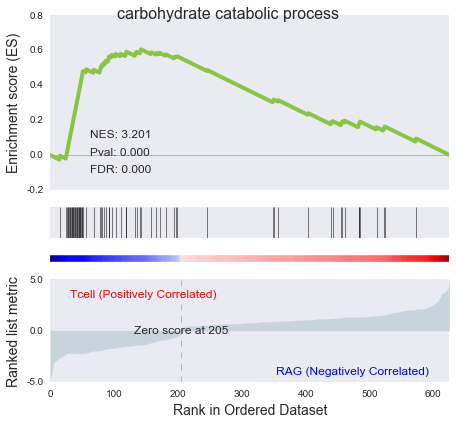

In [24]:
p = plot_gsea_result(bp_un_res.loc['GO:0016052'], unen_rank)
p.savefig(os.path.join(BASE, 'GSEA-carb-cat-proc.svg'))
p

### Cellular Component - Up in Tcell

In [25]:
cc_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0005737,cytoplasm,0.393,1.616,0.029,0.335,125,26


In [26]:
cc_un_TC[res_cols].to_csv(os.path.join(BASE,'cc_un_IBD.csv'))

### Molecular Function - Up in RAG

In [27]:
mf_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0016765,"transferase activity, transferring alkyl or ar...",-0.584,-2.191,1.914e-04,0.004,82,20
GO:0004478,methionine adenosyltransferase activity,-0.584,-2.171,1.955e-04,0.003,81,20
GO:0070566,adenylyltransferase activity,-0.610,-2.084,5.792e-04,0.006,21,15
GO:0022804,active transmembrane transporter activity,-0.661,-2.040,7.672e-04,0.006,96,11
GO:0022857,transmembrane transporter activity,-0.661,-2.023,2.354e-03,0.006,100,11
GO:0016820,"hydrolase activity, acting on acid anhydrides,...",-0.627,-1.862,4.818e-03,0.022,77,10
GO:0032559,adenyl ribonucleotide binding,-0.344,-1.832,1.549e-03,0.025,413,75
GO:0016817,"hydrolase activity, acting on acid anhydrides",-0.365,-1.824,3.249e-03,0.023,214,59
GO:0016779,nucleotidyltransferase activity,-0.355,-1.762,3.779e-03,0.034,183,57


In [28]:
mf_un_RAG[res_cols].to_csv(os.path.join(BASE,'mf_un_RAG.csv'))

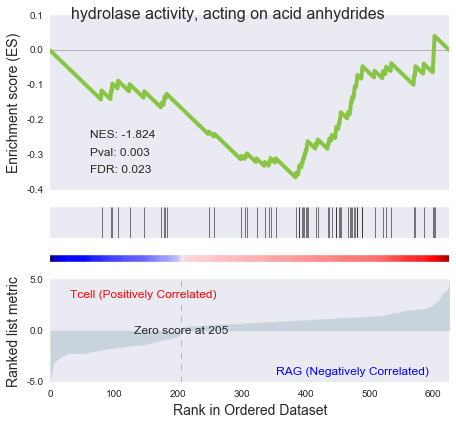

In [29]:
plot_gsea_result(mf_un_res.loc['GO:0016817'], unen_rank)

### Biological Process - Up in RAG

In [30]:
bp_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0006790,sulfur compound metabolic process,-0.569,-2.308,0.000e+00,5.453e-04,102,26
GO:0009108,coenzyme biosynthetic process,-0.587,-2.296,0.000e+00,2.726e-04,94,23
GO:1902578,single-organism localization,-0.720,-2.279,0.000e+00,2.045e-04,133,12
GO:0044272,sulfur compound biosynthetic process,-0.584,-2.188,0.000e+00,6.475e-04,81,20
GO:0051188,cofactor biosynthetic process,-0.538,-2.174,0.000e+00,5.725e-04,110,25
GO:0005978,glycogen biosynthetic process,-0.610,-2.085,7.682e-04,1.681e-03,21,15
GO:0034637,cellular carbohydrate biosynthetic process,-0.610,-2.085,1.522e-03,1.441e-03,35,15
GO:0005976,polysaccharide metabolic process,-0.610,-2.079,3.804e-04,1.363e-03,25,15
GO:0000271,polysaccharide biosynthetic process,-0.610,-2.077,1.142e-03,1.242e-03,22,15


In [31]:
bp_un_RAG[res_cols].to_csv(os.path.join(BASE,'bp_un_RAG.csv'))

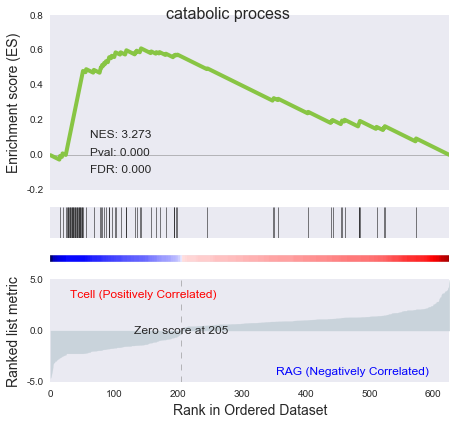

In [32]:
plot_gsea_result(bp_un_res.iloc[0], unen_rank)

### Cellular Component - Up in RAG

In [33]:
cc_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0044425,membrane part,-0.660,-2.341,0.000e+00,6.926e-04,123,17
GO:0098796,membrane protein complex,-0.669,-2.117,1.909e-04,3.809e-03,80,12
GO:0044422,organelle part,-0.507,-2.079,5.682e-04,3.540e-03,236,27
GO:0031224,intrinsic component of membrane,-0.797,-2.070,3.930e-04,2.915e-03,47,7
GO:0033178,"proton-transporting two-sector ATPase complex,...",-0.668,-1.816,6.588e-03,2.355e-02,42,8
GO:0044446,intracellular organelle part,-0.546,-1.676,2.628e-02,5.266e-02,115,11
GO:0044391,ribosomal subunit,-0.546,-1.668,2.649e-02,4.730e-02,89,11
GO:0044463,cell projection part,-0.484,-1.614,3.415e-02,5.919e-02,113,14
GO:0042995,cell projection,-0.484,-1.612,3.384e-02,5.337e-02,116,14


In [34]:
cc_un_RAG[res_cols].to_csv(os.path.join(BASE,'cc_un_RAG.csv'))

## GSEA on BioGlyCMK Enriched Samples

In [35]:
enr_rank =  make_ranked_df(enr_grouped_loci)

In [36]:
enr_mf_map = make_go2Gene_map(enr_grouped_loci)
enr_mf_map_f = filter_go2gene_map(enr_mf_map)
print('MF Unfiltered: {}\tFiltered: {}'.format(len(enr_mf_map), len(enr_mf_map_f)))

enr_bp_map = make_go2Gene_map(enr_grouped_loci, 'BP')
enr_bp_map_f = filter_go2gene_map(enr_bp_map)
print('BP Unfiltered: {}\tFiltered: {}'.format(len(enr_bp_map), len(enr_bp_map_f)))

enr_cc_map = make_go2Gene_map(enr_grouped_loci, 'CC')
enr_cc_map_f = filter_go2gene_map(enr_cc_map)
print('CC Unfiltered: {}\tFiltered: {}'.format(len(enr_cc_map), len(enr_cc_map_f)))

MF Unfiltered: 481	Filtered: 182
BP Unfiltered: 560	Filtered: 187
CC Unfiltered: 99	Filtered: 28


In [37]:
mf_enr_res = run_go_gsea(enr_rank, enr_mf_map_f, seed=1234)
bp_enr_res = run_go_gsea(enr_rank, enr_bp_map_f, seed=4321)
cc_enr_res = run_go_gsea(enr_rank, enr_cc_map_f, seed=2143)

101 gene_sets have been filtered out when max_size=500 and min_size=5
81 gene_sets used for further calculating
Start to compute enrichment socres...................... Wed Oct 26 15:48:34 2016
Start to compute esnulls................................ Wed Oct 26 15:48:34 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Wed Oct 26 15:49:23 2016
start to compute fdrs................................... Wed Oct 26 15:49:23 2016
Statistial testing finished............................. Wed Oct 26 15:49:24 2016
Start to generate gseapy reports, and produce figures... Wed Oct 26 15:49:24 2016
Start to generate gseapy reports, and produce figures... Wed Oct 26 15:49:24 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Wed Oct 26 15:49:24 2016
107 gene_sets have been filtered out when max_size=500 and min_size=5
80 gene_sets used for further calculating
Start 

In [38]:
mf_enr_res.to_csv(os.path.join(BASE, 'silam_mf_e.csv'))
bp_enr_res.to_csv(os.path.join(BASE, 'silam_bp_e.csv'))
cc_enr_res.to_csv(os.path.join(BASE, 'silam_cc_e.csv'))

In [39]:
mf_enr_TC = mf_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_enr_RAG = mf_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_enr_TC = bp_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_enr_RAG = bp_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

cc_enr_TC = cc_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
cc_enr_RAG = cc_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Up in T-Cell: Molecular Function

In [40]:
mf_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0008234,cysteine-type peptidase activity,0.927,2.305,0.000e+00,1.237e-04,24,7
GO:0008233,peptidase activity,0.757,2.239,0.000e+00,2.784e-04,70,12
GO:0004197,cysteine-type endopeptidase activity,0.925,2.179,0.000e+00,5.775e-04,16,6
GO:0004175,endopeptidase activity,0.831,2.169,1.799e-04,5.568e-04,29,8
GO:0016860,intramolecular oxidoreductase activity,0.795,1.981,1.081e-03,5.148e-03,32,7
GO:0016810,"hydrolase activity, acting on carbon-nitrogen ...",0.781,1.944,1.248e-03,6.527e-03,35,7
GO:0016787,hydrolase activity,0.424,1.926,4.323e-04,7.000e-03,267,64
GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl com...",0.589,1.790,1.005e-02,2.393e-02,31,13
GO:0016798,"hydrolase activity, acting on glycosyl bonds",0.566,1.744,1.321e-02,3.214e-02,33,14


In [41]:
mf_enr_TC[res_cols].to_csv(os.path.join(BASE,'mf_enr_TC.csv'))

In [42]:
obodag.query_term('GO:0016810')

GOTerm('GO:0016810'):
  alt_ids: 0 items
  name:hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds
  namespace:molecular_function
  children: 20 items
  _parents: 1 items
    GO:0016787
  parents: 1 items
    GO:0016787	level-02	depth-02	hydrolase activity [molecular_function] 
  depth:3
  level:3
  is_obsolete:False
  id:GO:0016810

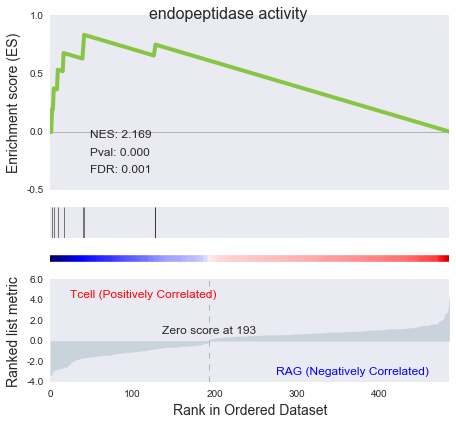

In [43]:
plot_gsea_result(mf_enr_res.loc['GO:0004175'], enr_rank)

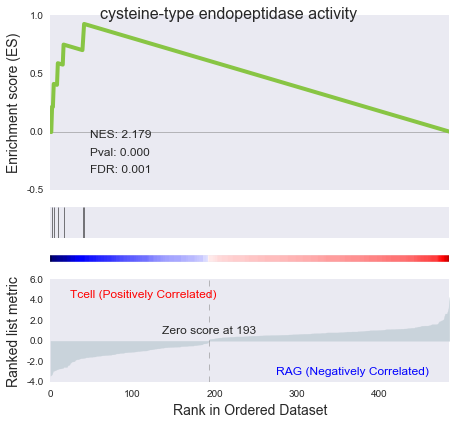

In [44]:
plot_gsea_result(mf_enr_res.loc['GO:0004197'], enr_rank)

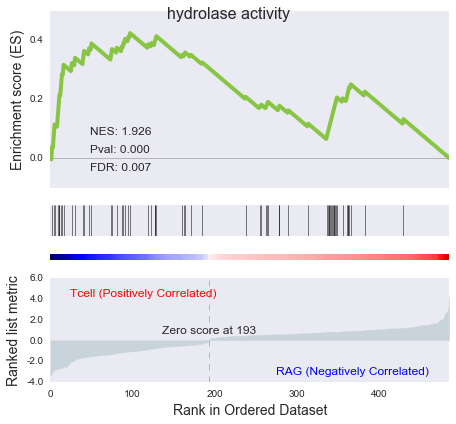

In [45]:
plot_gsea_result(mf_enr_res.loc['GO:0016787'], enr_rank)

### Up in T-Cell: Biological Process

In [46]:
bp_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0006508,proteolysis,0.757,2.243,0.000e+00,2.830e-04,67,12
GO:0019538,protein metabolic process,0.680,2.189,0.000e+00,5.661e-04,131,16
GO:0043170,macromolecule metabolic process,0.524,2.078,3.123e-04,2.610e-03,219,34
GO:0006520,cellular amino acid metabolic process,0.503,2.062,1.528e-04,2.571e-03,242,40
GO:0044248,cellular catabolic process,0.708,1.837,4.489e-03,3.310e-02,27,8
GO:0044712,single-organism catabolic process,0.405,1.798,2.164e-03,3.961e-02,143,58
GO:0009056,catabolic process,0.405,1.797,1.878e-03,3.421e-02,153,58
GO:0009259,ribonucleotide metabolic process,0.389,1.697,9.318e-03,7.139e-02,123,52
GO:0019693,ribose phosphate metabolic process,0.389,1.693,5.930e-03,6.557e-02,124,52


In [47]:
bp_enr_TC[res_cols].to_csv(os.path.join(BASE,'bp_enr_TC.csv'))

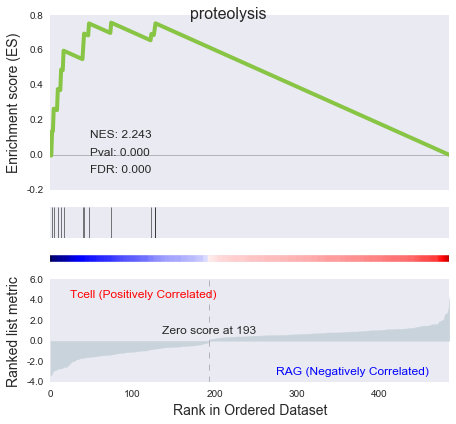

In [48]:
plot_gsea_result(bp_enr_res.loc['GO:0006508'], enr_rank)

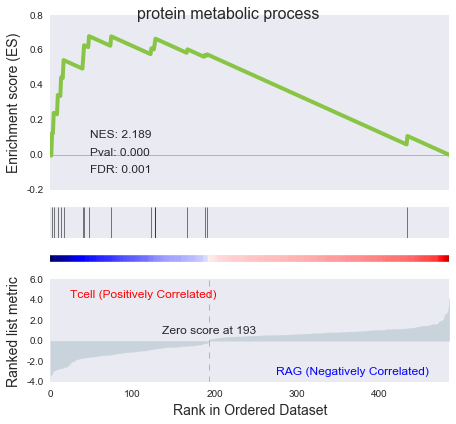

In [49]:
plot_gsea_result(bp_enr_res.loc['GO:0019538'], enr_rank)

### Up in T-Cell: Cellular Compnent

In [50]:
cc_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0016020,membrane,0.760,1.898,0.001,0.010,47,7
GO:0005737,cytoplasm,0.519,1.628,0.030,0.052,98,14


In [51]:
cc_enr_TC[res_cols].to_csv(os.path.join(BASE,'cc_enr_TC.csv'))

# RAG BioGlyCMK
### Up in RAG: Molecular Function

In [52]:
mf_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0016781,"phosphotransferase activity, paired acceptors",-0.835,-3.217,0.000e+00,0.000e+00,125,21
GO:0016772,"transferase activity, transferring phosphorus-...",-0.589,-2.752,0.000e+00,0.000e+00,241,40
GO:0032559,adenyl ribonucleotide binding,-0.501,-2.682,0.000e+00,0.000e+00,283,70
GO:0016740,transferase activity,-0.495,-2.643,0.000e+00,0.000e+00,384,70
GO:0016301,kinase activity,-0.630,-2.608,0.000e+00,0.000e+00,149,26
GO:0030554,adenyl nucleotide binding,-0.487,-2.605,0.000e+00,0.000e+00,291,72
GO:0004645,phosphorylase activity,-0.878,-2.506,0.000e+00,4.624e-05,18,9
GO:0001883,purine nucleoside binding,-0.436,-2.382,0.000e+00,8.092e-05,353,77
GO:0097367,carbohydrate derivative binding,-0.436,-2.382,0.000e+00,7.193e-05,363,77


In [53]:
mf_enr_RAG[res_cols].to_csv(os.path.join(BASE,'mf_enr_RAG.csv'))

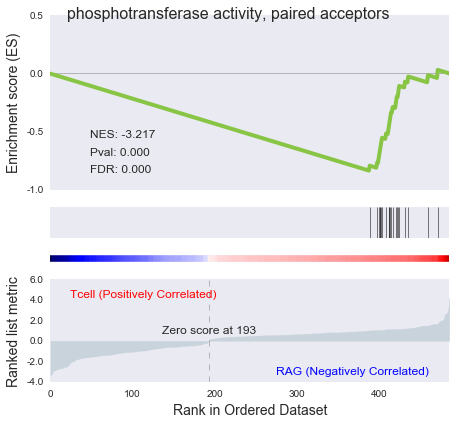

In [54]:
plot_gsea_result(mf_enr_res.loc['GO:0016781'], enr_rank)

### Up in RAG: Biological Process

In [55]:
bp_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0016051,carbohydrate biosynthetic process,-0.675,-2.511,0.000e+00,0.000e+00,72,19
GO:0030001,metal ion transport,-0.752,-2.331,0.000e+00,1.099e-04,27,11
GO:0006814,sodium ion transport,-0.752,-2.327,0.000e+00,7.325e-05,24,11
GO:0015672,monovalent inorganic cation transport,-0.752,-2.320,0.000e+00,5.494e-05,29,11
GO:0006811,ion transport,-0.752,-2.313,0.000e+00,6.593e-05,35,11
GO:0006812,cation transport,-0.752,-2.305,0.000e+00,1.099e-04,33,11
GO:0046364,monosaccharide biosynthetic process,-0.591,-1.981,2.889e-03,5.777e-03,45,14
GO:0006090,pyruvate metabolic process,-0.352,-1.882,0.000e+00,1.276e-02,236,70
GO:0016310,phosphorylation,-0.352,-1.871,0.000e+00,1.238e-02,244,70


In [56]:
bp_enr_RAG[res_cols].to_csv(os.path.join(BASE,'bp_enr_RAG.csv'))

### Up in RAG: Cellular Component

In [57]:
cc_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Term,,,,,,,
GO:0098796,membrane protein complex,-0.539,-1.818,0.009,0.084,29,14
GO:1990351,transporter complex,-0.538,-1.784,0.013,0.055,16,13
GO:0044459,plasma membrane part,-0.538,-1.760,0.014,0.044,20,13
GO:1904949,ATPase complex,-0.538,-1.760,0.012,0.033,16,13
GO:0043190,ATP-binding cassette (ABC) transporter complex,-0.538,-1.750,0.014,0.028,15,13
GO:0098797,plasma membrane protein complex,-0.538,-1.750,0.015,0.024,19,13


In [58]:
cc_enr_RAG[res_cols].to_csv(os.path.join(BASE,'cc_enr_RAG.csv'))